### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud

STOPWORDS = set(stopwords.words('english'))

### Load Datasets
Integrating datasets into two data frames, True and False

In [2]:
dfFake = pd.read_csv('Data/archive/Fake.csv')
dfFake['label'] = 'Fake'
del dfFake['subject']
del dfFake['date']

dfFake

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,Fake
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Fake
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Fake
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Fake
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Fake


In [3]:
dfTrue = pd.read_csv('Data/archive/True.csv')
dfTrue['label'] = 'True'
del dfTrue['subject']
del dfTrue['date']

dfTrue

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,True
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,True


#### Modified data quality report
Helps determine what cleaning needs to be done

In [4]:
def quality_report(df):
  # Constructing a data quality report for the data
  cat_data = {'Feature': ['title', 'text', 'label'],
              'Count': df.count(),
              '% Missing': df.isnull().sum() * 100 / len(df),
              'Cardinality': df.apply(pd.Series.nunique),
              'Mode': [df.mode()['title'][0], 'null', df.mode()['label'][0]],
              'Mode Freq.': ['14', '769', '39644'],
              'Mode %': [14 / 63552 * 100, 769 / 64186 * 100 , 39644 / 64232 * 100],
      
              'Notes': ['', '', '']}
  cat_dqr_df = pd.DataFrame(cat_data)
  cat_dqr_df.reset_index(drop=True, inplace=True)

  return cat_dqr_df

In [5]:
print("Quality Report True Dataset")
quality_report(dfTrue).head()


Quality Report True Dataset


,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,21417,0.0,20826,Factbox: Trump fills top jobs for his administ...,14,0.022029,
1,text,21417,0.0,21192,null,769,1.198081,
2,label,21417,0.0,1,True,39644,61.720015,


In [6]:
print("Quality Report Fake Dataset")
quality_report(dfFake).head()

Quality Report Fake Dataset


,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,23481,0.0,17903,MEDIA IGNORES Time That Bill Clinton FIRED His...,14,0.022029,
1,text,23481,0.0,17455,null,769,1.198081,
2,label,23481,0.0,1,Fake,39644,61.720015,


In [7]:
# Build project using 20% 
dfTrue = dfTrue.head(int(0.20 * dfTrue.shape[0]))
dfFake = dfFake.head(int(0.20 * dfFake.shape[0]))

### Data Preprocessing
Removing stopwords, punctuation, and whitespace characters and Stemming

In [8]:
def clean_string(input):
  ps = PorterStemmer()
  
  input = re.sub('[^a-zA-Z]', ' ', input)  # Remove special characters and spaces
  input = input.lower()                    # Lowercase all text

  input = input.split()  # Seperate into array of words
  input = [ps.stem(word) for word in input if not word in STOPWORDS] # Remove stopwords and replace word with stem
  input = ' '.join(input)  # Combine back into sentence             
  
  return input

def preprocess(df):
  copy = df.copy()
  copy.drop_duplicates(inplace = True) # Remove duplicates
  copy.dropna(axis=0, inplace = True)  # Remove rows with missing values
  cleanfunc = np.vectorize(clean_string)    # Use vectorization to increase speed
  copy['title'] = cleanfunc(copy['title'])  # Clean titles
  copy['text'] = cleanfunc(copy['text'])    # Clean text 
  return copy

In [9]:
dfTrue = preprocess(dfTrue)
dfFake = preprocess(dfFake)

In [10]:
dfTrue.head()

,title,text,label
0,u budget fight loom republican flip fiscal script,washington reuter head conserv republican fact...,True
1,u militari accept transgend recruit monday pen...,washington reuter transgend peopl allow first ...,True
2,senior u republican senat let mr mueller job,washington reuter special counsel investig lin...,True
3,fbi russia probe help australian diplomat tip nyt,washington reuter trump campaign advis georg p...,True
4,trump want postal servic charg much amazon shi...,seattl washington reuter presid donald trump c...,True


In [11]:
dfFake.head()

,title,text,label
0,donald trump send embarrass new year eve messa...,donald trump wish american happi new year leav...,Fake
1,drunk brag trump staffer start russian collus ...,hous intellig committe chairman devin nune go ...,Fake
2,sheriff david clark becom internet joke threat...,friday reveal former milwauke sheriff david cl...,Fake
3,trump obsess even obama name code websit imag,christma day donald trump announc would back w...,Fake
4,pope franci call donald trump christma speech,pope franci use annual christma day messag reb...,Fake


### Data Exploration & Visualization

#### Character Count in Title and Text

In [12]:
# Returns the char count for specified field
def getCharCount(df, field):
  return [len(text) for text in df[field].to_list()]

# Visualize char count of field in histogram
def histogram_char_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Characters")
  plt.ylabel("News")
  plt.title(f'Character Count Distribution of {field} in {label} News')
  plt.show()

def plot_avg_char_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Characters'])
  df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Characters', title=f'Average Character Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  
# Calculate and visualize character count statistics
def character_stats(dfTrue, dfFake, field):
  print(f"Character Count Distribution of {field}")
  true_char_count= getCharCount(dfTrue, field)
  histogram_char_count(dfTrue, true_char_count, field, "True")

  fake_char_count = getCharCount(dfFake, field)
  histogram_char_count(dfFake, fake_char_count, field, "Fake") 

  print(f"Average Count of {field}")
  plot_avg_char_count(dfTrue, dfFake, field, true_char_count, fake_char_count)

Character Count Distribution of title


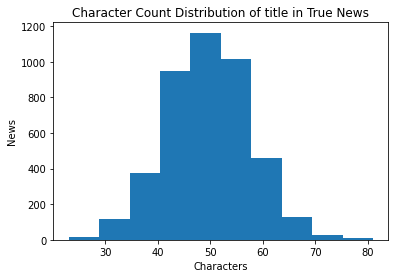

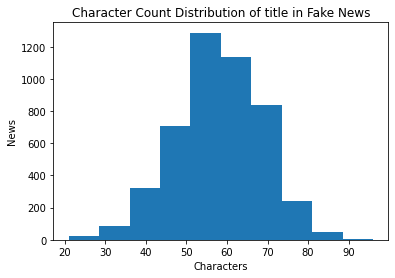

Average Count of title


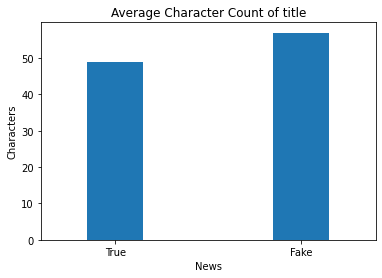

Character Count Distribution of text


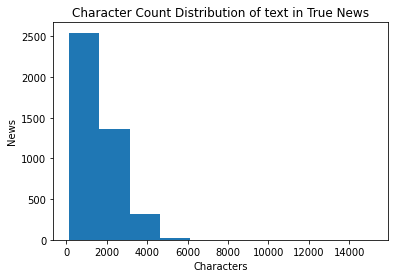

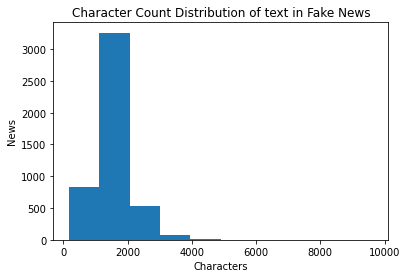

Average Count of text


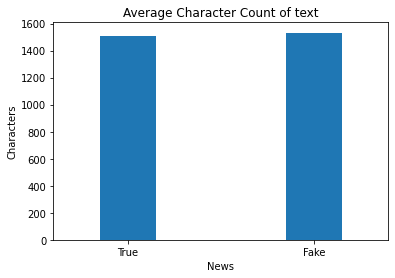

In [13]:
character_stats(dfTrue, dfFake, 'title')
character_stats(dfTrue, dfFake, 'text')

#### Word count in Title and Text

In [14]:
vectorizer = CountVectorizer()

# Returns the char count for specified field
def getWordCount(df, field):
  counts = []
  for text in df[field].to_list():
    text_count = np.sum(vectorizer.fit_transform([text]).toarray())
    counts.append(text_count)
  return counts

# Visualize word count of field in histogram
def histogram_word_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Words")
  plt.ylabel("News")
  plt.title(f'Word Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_word_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Words'])
  df.plot(x='News', y='Words', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Word Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  
# Calculate and visualize word count statistics
def word_stats(dfTrue, dfFake, field):
  print(f"Word Count Distribution of {field}")
  true_word_count= getWordCount(dfTrue, field)
  histogram_word_count(dfTrue, true_word_count, field, "True")

  fake_word_count = getWordCount(dfFake, field)
  histogram_word_count(dfFake, fake_word_count, field, "Fake") 

  print(f"Average count of {field}")
  plot_avg_word_count(dfTrue, dfFake, field, true_word_count, fake_word_count)


Word Count Distribution of title


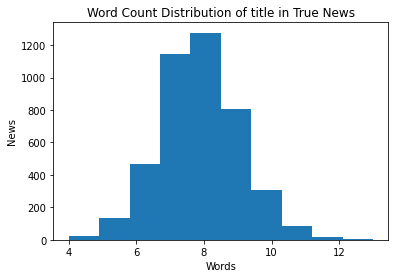

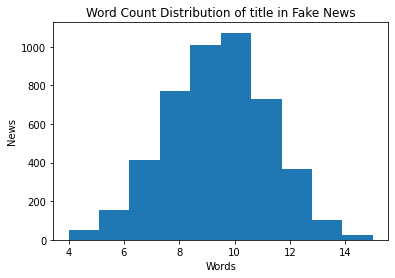

Average count of title


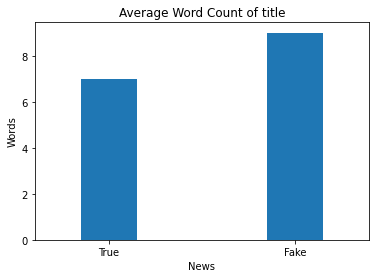

Word Count Distribution of text


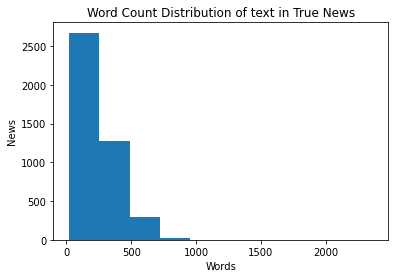

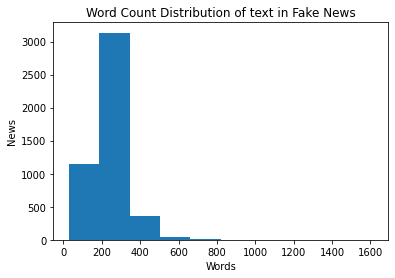

Average count of text


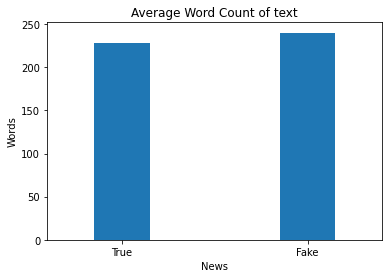

In [15]:
word_stats(dfTrue, dfFake, 'title')
word_stats(dfTrue, dfFake, 'text')

#### Visualize Frequent Words with WordCloud

In [16]:
def generateWordCloud(df, feature):
  wordcloud = WordCloud(max_words=30).generate(' '.join(df[feature].tolist()))
  
  # plot the WordCloud                      
  plt.figure(figsize = (10, 10), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()


WordCloud for Fake News Titles


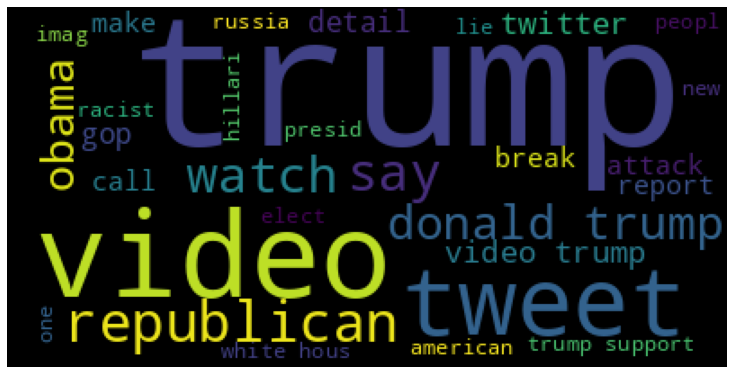

WordCloud for Fake News Text


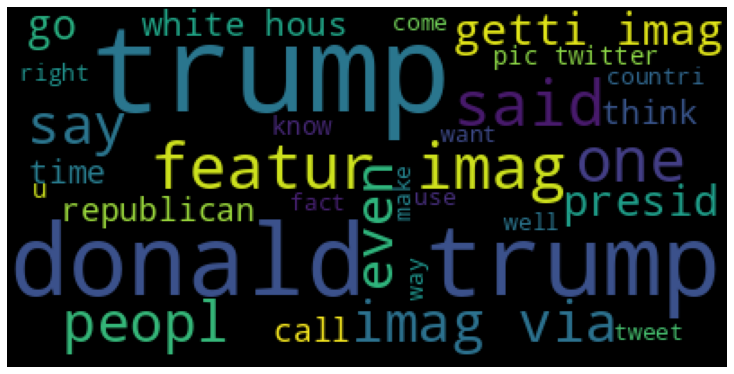

In [17]:
# Visualize most significant words for fake news
print("WordCloud for Fake News Titles")
generateWordCloud(dfFake, 'title')
print("WordCloud for Fake News Text")
generateWordCloud(dfFake, 'text')

WordCloud for True News Titles


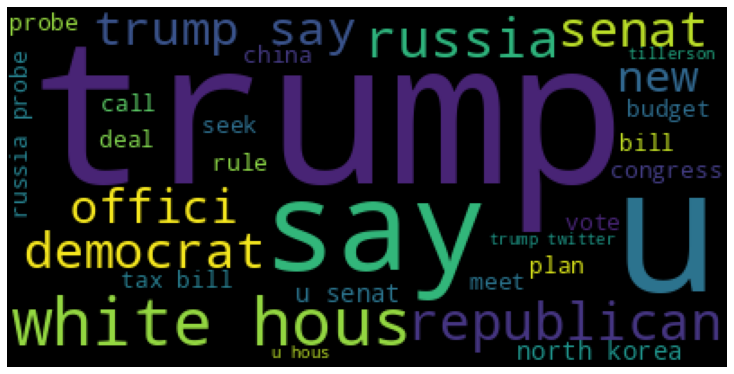

WordCloud for True News Text


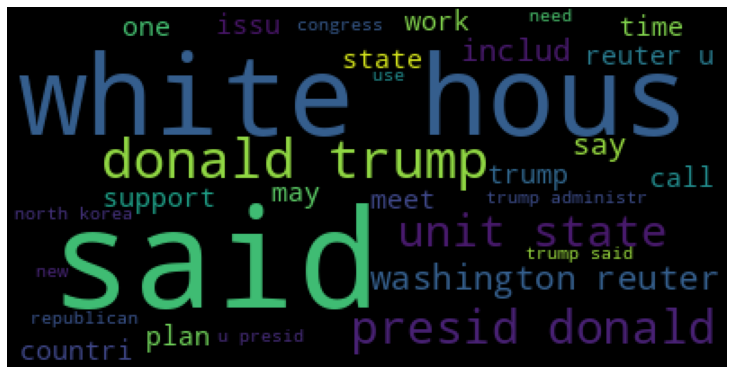

In [18]:
# Visualize most significant words for true news
print("WordCloud for True News Titles")
generateWordCloud(dfTrue, 'title')
print("WordCloud for True News Text")
generateWordCloud(dfTrue, 'text')

### Classifications

#### Combine Text and Title

In [19]:
def combine_text_title(df, label):
  newdf = pd.DataFrame()
  content = zip(df['title'].to_list(), df['text'].to_list())
  newdf['content'] = [str(title + text) for title, text in content]
  newdf['label'] = [ label for i in range(df.shape[0]) ]  # Add label
  # df.drop(columns = ['title', 'text'], inplace=True)
  return newdf

In [20]:
dfFake = combine_text_title(dfFake, 'Fake')
dfTrue = combine_text_title(dfTrue, 'True')

#### Create Train and Test Sets

In [21]:
dataset = pd.concat([dfTrue, dfFake]) # Combine True and Fake datasets 
train_set, test_set = train_test_split(dataset, train_size=0.7)
train_set.reset_index(drop=True)
test_set.reset_index(drop=True)

,content,label
0,new mexico eras actual scienc scienc standarde...,Fake
1,trump host lunch republican senat obamacar rep...,True
2,fbi raid ex trump aid home show russia probe i...,True
3,report hillari want joe biden huge role white ...,Fake
4,trump son law kushner congression statementwas...,True
...,...,...
2682,instant view reaction disband trump busi counc...,True
2683,boehner trump complet disastwashington reuter ...,True
2684,republican senat block arm sale qatar crisiwas...,True
2685,china foreign minist peac agreement right choi...,True


#### Create Different Term Vector Models
A term vector model is an algebraic model for representing text documents

In [22]:
# Create specified vector model using vectorizer
def create_vector_model(vectorizer, train_set, test_set):
  train_labels = train_set['label']
  test_labels = test_set['label']

  train_set = vectorizer.fit_transform(train_set['content'])
  test_set = vectorizer.transform(test_set['content'])


  return train_set, train_labels, test_set, test_labels

Simple Count Vector Model
- The simplest vector encoding model is to simply fill in the vector with the frequency of each word as it appears in the document.4
- A disadvatage of being a sparse matrix with many values being zero

In [23]:
# Create simple count vector model of dataset
count_v = CountVectorizer()
count_vector_model = create_vector_model(count_v, train_set, test_set)

cv_train_set = count_vector_model[0]
cv_test_set = count_vector_model[2]


print(f'Train set: {cv_train_set.get_shape()}')
print(f'Test set: {cv_test_set.get_shape()}')

Train set: (6269, 36475)
Test set: (2687, 36475)


TF-IDF Vector Model
- Term frequency–inverse document frequency, normalizes the frequency of words in a document with respect to the rest of the dataset.

In [24]:
# Create TF-IDF vector model of dataset
tfidf_v = TfidfVectorizer(max_features=2000, ngram_range=(1,3))  # Get 5000 most significant words
tfidf_vector_model = create_vector_model(tfidf_v, train_set, test_set)

In [25]:
tv_train_set, tv_train_labels, tv_test_set, tv_test_labels = tfidf_vector_model

tv_train_set.get_shape()

(6269, 2000)

#### Classfication Methods

In [26]:
# Apply specified classification method and provide performance metrics
def classify(method, vector_model, wm = False, arr = False):
  train_set, train_labels, test_set, test_labels = vector_model # Get sets and labels from model
  
  if arr:
    train_set = train_set.toarray()
    test_set = test_set.toarray()
  
  pipeline = make_pipeline(StandardScaler(with_mean=wm), method)  # Pipeline standardize data then use given classification method
  pipeline.fit(train_set, train_labels)
  pipeline.score(test_set, test_labels)
  predictions = pipeline.predict(test_set)

  cr = classification_report(test_labels, predictions)
  accuracy = accuracy_score(test_labels, predictions)
  conf_matrix = ConfusionMatrixDisplay.from_predictions(test_labels, predictions)

  print(cr)
  print(f'Accuracy: {accuracy*100} %')
  print(f"Confusion Matrix:")
  conf_matrix
  
  return zip(test_labels, predictions)

#### Logistic Regression


Count Vector Model

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      1452
        True       0.99      0.98      0.99      1235

    accuracy                           0.99      2687
   macro avg       0.99      0.99      0.99      2687
weighted avg       0.99      0.99      0.99      2687

Accuracy: 98.6602158541124 %
Confusion Matrix:


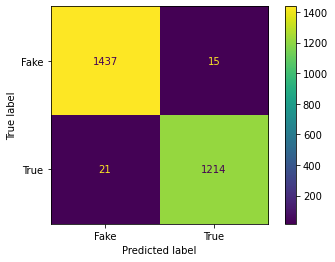

In [27]:
LR_CV = classify(LogisticRegression(), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      1452
        True       1.00      1.00      1.00      1235

    accuracy                           1.00      2687
   macro avg       1.00      1.00      1.00      2687
weighted avg       1.00      1.00      1.00      2687

Accuracy: 99.81391886862671 %
Confusion Matrix:


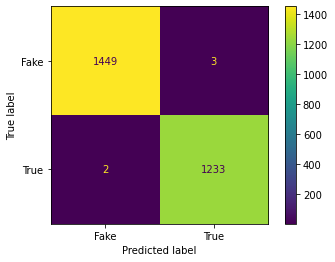

In [28]:
LR_TV = classify(LogisticRegression(), tfidf_vector_model)

#### Decision Tree Classifier

Count Vector Model

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      1452
        True       0.99      0.99      0.99      1235

    accuracy                           0.99      2687
   macro avg       0.99      0.99      0.99      2687
weighted avg       0.99      0.99      0.99      2687

Accuracy: 99.29289170078154 %
Confusion Matrix:


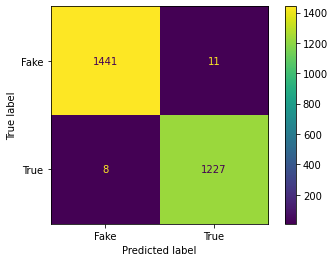

In [29]:
DT_CV = classify(DecisionTreeClassifier(max_depth=5), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      1452
        True       0.99      0.99      0.99      1235

    accuracy                           0.99      2687
   macro avg       0.99      0.99      0.99      2687
weighted avg       0.99      0.99      0.99      2687

Accuracy: 99.0695943431336 %
Confusion Matrix:


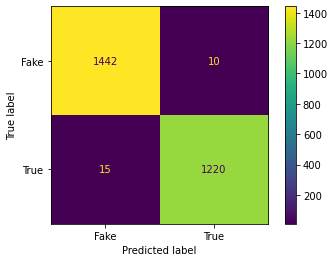

In [30]:
DT_TV = classify(DecisionTreeClassifier(), tfidf_vector_model)


#### Support Vector Machines Classifier

Count Vector Model

              precision    recall  f1-score   support

        Fake       0.98      0.99      0.99      1452
        True       0.99      0.98      0.98      1235

    accuracy                           0.99      2687
   macro avg       0.99      0.99      0.99      2687
weighted avg       0.99      0.99      0.99      2687

Accuracy: 98.62299962783774 %
Confusion Matrix:


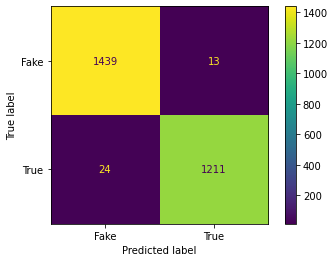

In [31]:

SVM_CV = classify(SVC(kernel="linear"), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      1452
        True       1.00      1.00      1.00      1235

    accuracy                           1.00      2687
   macro avg       1.00      1.00      1.00      2687
weighted avg       1.00      1.00      1.00      2687

Accuracy: 99.85113509490138 %
Confusion Matrix:


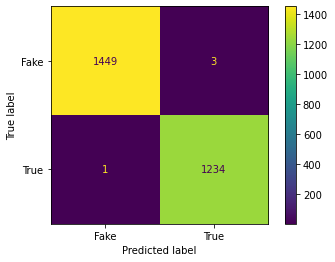

In [32]:
SVM_TV = classify(SVC(kernel="linear"), tfidf_vector_model)

#### Naive Bayes Classifier

Count Vector Model

              precision    recall  f1-score   support

        Fake       0.95      0.91      0.93      1452
        True       0.90      0.95      0.92      1235

    accuracy                           0.93      2687
   macro avg       0.92      0.93      0.93      2687
weighted avg       0.93      0.93      0.93      2687

Accuracy: 92.55675474506884 %
Confusion Matrix:


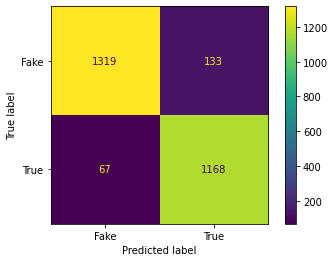

In [33]:
NB_CV = classify(MultinomialNB(), count_vector_model)

TF-IDF Vector Model

              precision    recall  f1-score   support

        Fake       0.98      0.99      0.99      1452
        True       0.99      0.98      0.98      1235

    accuracy                           0.98      2687
   macro avg       0.99      0.98      0.98      2687
weighted avg       0.98      0.98      0.98      2687

Accuracy: 98.47413472273911 %
Confusion Matrix:


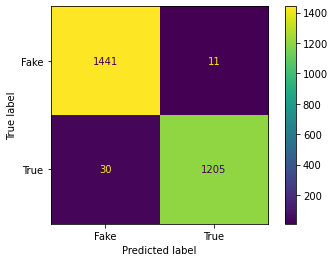

In [34]:
NB_TV = classify(MultinomialNB(), tfidf_vector_model)

#### Observations

**Logisitic Regression**

The logistic regression classifier was the best performing classifier with an accuracy of _% given with the simple count vector model and _% with TF-IDF vector model. Logistic Regression is a discriminative algorithm that determines the border between the two classes and determines classification based on the highest conditional probability.  Logistic Regression performs well on data that can easily be split linearly. This tells us that based on the features there is a clear distinction between "True" and "Fake" news